In [245]:
import pandas as pd
#Scraping With GetOldTweets3
#!pip install GetOldTweets3
#import GetOldTweets3 as got
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
ps = PorterStemmer()
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [134]:
!pwd

/content


### Read Data

In [0]:
data = pd.read_excel("./tweet_cleaned_data.xlsx")


In [247]:
###Length of Dataset
len(data["cleaned_text"])

2446

In [0]:
new_df = data.filter(['date','cleaned_text'], axis=1)


### Club tweet of each Day

In [0]:
new_df=new_df.groupby('date')['cleaned_text'].agg(lambda x: ' '.join(x.astype(str))).reset_index()

In [251]:
len(new_df)

91

### In below steps the TF and IDF of tweets of each day is calculated

In [0]:
from past.builtins import xrange
nums = [0,len(new_df["cleaned_text"])]

clean_tweet_texts = []
for i in xrange(nums[0],nums[1]):
  clean_tweet_texts.append((new_df.loc[i,"cleaned_text"]))
    #clean_tweet_texts.append(clean_tweet(data['tweet_text'][i]))

In [0]:
tweet_eachDay=[]
for sentecnce in clean_tweet_texts:
    tweet_eachDay.append(str(sentecnce).split())

In [0]:
# calculating DF
DF = {}
for i in range(len(tweet_eachDay)):
    tokens = tweet_eachDay[i]
    #print(tokens)
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}
#print(DF)

In [0]:
### finding the frequency of the word 
for i in DF:
    DF[i]= len(DF[i])
#DF

In [0]:
# calculating TF-IDF
import collections
tf_idf = {}
N = len(tweet_eachDay)
tf_idf_allDays =[]
for i in range(N):
    tokens = tweet_eachDay[i]
    # print(tokens)
    counter = collections.Counter(tokens)
    words_count = len(tokens)
    tf_idf_eachday ={}
    for token in np.unique(tokens):
        tf = counter[token]/words_count
        df = DF[token]
        
        idf = np.log(N/df)
        #tf_idf[token,i] = (tf*idf,i)
    
        tf_idf_eachday[token] =tf*idf
    tf_idf_allDays.append(tf_idf_eachday)  

### In below Section the Loghurn negative word doc is imported to do analysis how much negative sentiment tweets carry for given date

In [0]:
negative_word =[]
with open('./loghurn_negative.txt') as f:
    negative_word = f.read().splitlines()

In [259]:
len(tweet_eachDay)

91

###Negative Sentiment Score is calculated in below section.

In [0]:
sentiment_score=[]
neg_word_number=[]
for i in range(len(tf_idf_allDays)):
    tf_idf_dict = tf_idf_allDays[i]
    word_counter=0
    
    line_sent_score=0
    for word,score in tf_idf_dict.items():
      
      if word.upper() in negative_word:
        word_counter =word_counter+1
        line_sent_score=line_sent_score+score
    #print(line_sent_score)
    sentiment_score.append(line_sent_score)
    neg_word_number.append(word_counter)

In [0]:
new_df["sentiment_score"]=sentiment_score

In [0]:
new_df["neg_word_count"]=neg_word_number

In [263]:
### check the dataset with sentiment score
new_df

,date,cleaned_text,sentiment_score,neg_word_count
0,2019-12-31,know lot well worth minut read trader need rea...,0.069354,22
1,2020-01-01,wisdom let get done conserv kag kag kaga kag l...,0.159233,14
2,2020-01-02,rakesh jhunjhunwala check iifl secur keep mind...,0.167102,11
3,2020-01-03,track stockmarket reaction us airstrik kill so...,0.148410,12
4,2020-01-04,much fun make ten minut see lol click link ful...,0.120236,11
...,...,...,...,...
86,2020-03-26,bear bullmarket shortest ever amount time stoc...,0.120656,39
87,2020-03-27,week spx comp dow stock stockmarket investor i...,0.110930,20
88,2020-03-28,good exampl prep correctli took book good trad...,0.056469,10
89,2020-03-29,economist chart given world coronaviru china w...,0.126032,12


### in the following section the sentiment score is divided by total word to normalize the sentiment score.

In [0]:
from past.builtins import xrange
nums = [0,len(new_df["cleaned_text"])]
#nums = [0,3000]
normalized_sentiment_score = []
for i in xrange(nums[0],nums[1]):

  word_count=len(new_df.loc[i,"cleaned_text"].split(" "))
  #print(word_count)
  normalized_score=(new_df.loc[i,"sentiment_score"])/word_count
  normalized_sentiment_score.append(normalized_score)
  #print(normalized_sentiment_score)
     

In [0]:
new_df["normalized_sentiment_score"]=normalized_sentiment_score

In [267]:
new_df.sort_values('normalized_sentiment_score')

,date,cleaned_text,sentiment_score,neg_word_count,normalized_sentiment_score
21,2020-01-21,last week interview insight think pick stock s...,0.063981,24,0.000075
27,2020-01-27,never see peopl impact diseas lot scari headli...,0.055506,21,0.000075
45,2020-02-14,govern help buy record price stock valuat gold...,0.017850,4,0.000079
28,2020-01-28,new setup nflx need hold specif zone trade fib...,0.075532,27,0.000084
14,2020-01-14,jan us stock close mix dow hit intraday high e...,0.072631,23,0.000092
...,...,...,...,...,...
32,2020-02-01,anyon shoot nifti economi go wrong similar typ...,0.172558,11,0.001135
54,2020-02-23,tire learn stockmarket children tire learn day...,0.205695,12,0.001143
2,2020-01-02,rakesh jhunjhunwala check iifl secur keep mind...,0.167102,11,0.001202
5,2020-01-05,translat blown debt bubbl economi collaps go d...,0.109944,3,0.001222


### In the following section Dow dataset for those date range is imported for further analysis.

In [271]:
dow_stock=pd.read_excel('./Dow.xlsx')
dow_stock=dow_stock[2:][['Attributes','Close']].rename(columns={"Attributes": "date","Close":"Prices"}).reset_index(drop=True)
dow_stock['date']=dow_stock['date'].dt.strftime('%Y-%m-%d')
dow_stock.head()

,date,Prices
0,2020-01-02,53.75
1,2020-01-03,52.42
2,2020-01-06,52.21
3,2020-01-07,52.19
4,2020-01-08,52.73


In [0]:
#Adding a "Price" column in our dataframe and fetching the stock price as per the date in our dataframe
new_df['DowPrices']=""

In [0]:
indx=0
for i in range (0,len(new_df)):
    for j in range (0,len(dow_stock)):
        get_tweet_date=new_df.date.iloc[i]
        get_stock_date=dow_stock.date.iloc[j]
        if(str(get_stock_date)==str(get_tweet_date)):
            #print(get_stock_date," ",get_tweet_date)

            new_df.at[i,'DowPrices'] = float(dow_stock.Prices[j])
            break

In [274]:
new_df

,date,cleaned_text,sentiment_score,neg_word_count,normalized_sentiment_score,DowPrices
0,2019-12-31,know lot well worth minut read trader need rea...,0.069354,22,0.000105,
1,2020-01-01,wisdom let get done conserv kag kag kaga kag l...,0.159233,14,0.001034,
2,2020-01-02,rakesh jhunjhunwala check iifl secur keep mind...,0.167102,11,0.001202,53.75
3,2020-01-03,track stockmarket reaction us airstrik kill so...,0.148410,12,0.000753,52.42
4,2020-01-04,much fun make ten minut see lol click link ful...,0.120236,11,0.000523,
...,...,...,...,...,...,...
86,2020-03-26,bear bullmarket shortest ever amount time stoc...,0.120656,39,0.000164,29.68
87,2020-03-27,week spx comp dow stock stockmarket investor i...,0.110930,20,0.000302,28.56
88,2020-03-28,good exampl prep correctli took book good trad...,0.056469,10,0.000206,
89,2020-03-29,economist chart given world coronaviru china w...,0.126032,12,0.000589,


### The missing valus for Dow data for weekendsand holidays are handled in the below section with FFIL method.

In [0]:
#Forward fill NaN values in the Prices Column
new_df['DowPrices'] = new_df['DowPrices'].replace('', np.NaN)
new_df['DowPrices'] = new_df['DowPrices'].fillna(method='ffill')


In [276]:
new_df

,date,cleaned_text,sentiment_score,neg_word_count,normalized_sentiment_score,DowPrices
0,2019-12-31,know lot well worth minut read trader need rea...,0.069354,22,0.000105,NaN
1,2020-01-01,wisdom let get done conserv kag kag kaga kag l...,0.159233,14,0.001034,NaN
2,2020-01-02,rakesh jhunjhunwala check iifl secur keep mind...,0.167102,11,0.001202,53.750000
3,2020-01-03,track stockmarket reaction us airstrik kill so...,0.148410,12,0.000753,52.419998
4,2020-01-04,much fun make ten minut see lol click link ful...,0.120236,11,0.000523,52.419998
...,...,...,...,...,...,...
86,2020-03-26,bear bullmarket shortest ever amount time stoc...,0.120656,39,0.000164,29.680000
87,2020-03-27,week spx comp dow stock stockmarket investor i...,0.110930,20,0.000302,28.559999
88,2020-03-28,good exampl prep correctli took book good trad...,0.056469,10,0.000206,28.559999
89,2020-03-29,economist chart given world coronaviru china w...,0.126032,12,0.000589,28.559999


In [0]:
new_df =new_df.dropna()

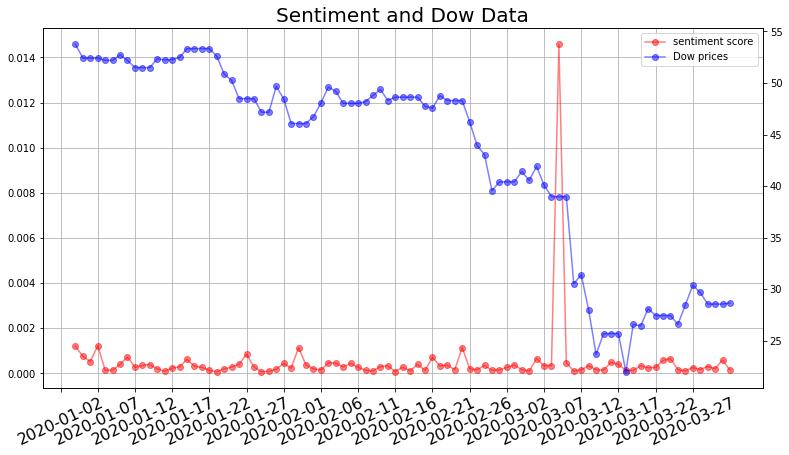

In [284]:
fig = plt.figure(figsize=(10, 5))
line_weight = 3
alpha = .5
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
# This is the magic that joins the x-axis
ax2 = ax1.twinx()
lns1 = ax1.plot(new_df['normalized_sentiment_score'], color='red', alpha=alpha, marker='o',label='sentiment score')
lns2 = ax2.plot(new_df['DowPrices'], color='blue', alpha=alpha,marker='o', label='Dow prices')
# Solution for having two legends

ax1.set_xticks(list(range(0, 90, 5)))
ax1.set_xticklabels(new_df.iloc[::5,0], rotation=25,fontsize=16)
leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
plt.title('Sentiment and Dow Data', fontsize=20)
ax1.grid()        
plt.show()

#Obeservation:
In the above plot the dow data and the normalized negative score is plotted with date on X axis. We can observer that when is there is spike in the negative sentiment it has impacted the Dow price of followinf day or days.It is clearly visible that is high negative score between date range March 2nd 2020 and March 7 2020. then we can observe a trend that the DOw price has a sharp decline between March 7th 2020 to March 12th 2020.The First official death due to Covid-19 was declared on March 1st in Washington state.that migh have impacted high negative sentiment score between 2nd of March to 7th of March.


###Scaling Data

##### from the dataset it is observed that the scale of "normalized sentiment score and dow prices to put in same scale. and one negative score is too high which dominates the graph plotted above and other are not properly visible.to do further analysis in below section the high negative score is dropped and data is scaled to plot in another graph.

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [0]:
### drop the data with high sentiment
new_df_updated =new_df.drop(index=67)

In [0]:
new_df_updated[['normalized_sentiment_score','DowPrices']] = scaler.fit_transform(new_df_updated[['normalized_sentiment_score','DowPrices']])

In [288]:
new_df_updated.sort_values('normalized_sentiment_score',ascending=False)

,date,cleaned_text,sentiment_score,neg_word_count,normalized_sentiment_score,DowPrices
5,2020-01-05,translat blown debt bubbl economi collaps go d...,0.109944,3,1.000000,0.958110
2,2020-01-02,rakesh jhunjhunwala check iifl secur keep mind...,0.167102,11,0.983058,1.000000
54,2020-02-23,tire learn stockmarket children tire learn day...,0.205695,12,0.931252,0.828346
32,2020-02-01,anyon shoot nifti economi go wrong similar typ...,0.172558,11,0.924717,0.758110
25,2020-01-25,stockmarket ponzi scheme eventu must collaps g...,0.183863,18,0.673674,0.834331
...,...,...,...,...,...,...
14,2020-01-14,jan us stock close mix dow hit intraday high e...,0.072631,23,0.014938,0.952441
28,2020-01-28,new setup nflx need hold specif zone trade fib...,0.075532,27,0.008318,0.792441
45,2020-02-14,govern help buy record price stock valuat gold...,0.017850,4,0.003848,0.838740
27,2020-01-27,never see peopl impact diseas lot scari headli...,0.055506,21,0.000382,0.793071


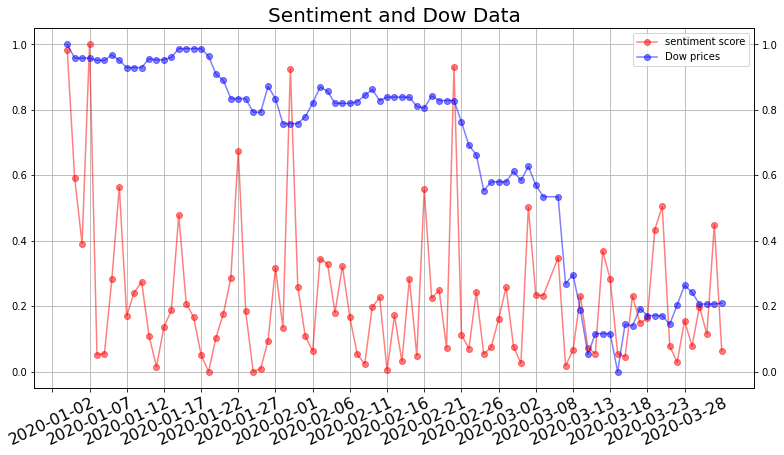

In [289]:
fig = plt.figure(figsize=(10, 5))
line_weight = 3
alpha = .5
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
# This is the magic that joins the x-axis
ax2 = ax1.twinx()
lns1 = ax1.plot(new_df_updated['normalized_sentiment_score'], color='red', alpha=alpha, marker='o',label='sentiment score')
lns2 = ax2.plot(new_df_updated['DowPrices'], color='blue', alpha=alpha,marker='o', label='Dow prices')
# Solution for having two legends

ax1.set_xticks(list(range(0, 90, 5)))
ax1.set_xticklabels(new_df_updated.iloc[::5,0], rotation=25,fontsize=16)
leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
plt.title('Sentiment and Dow Data', fontsize=20)
ax1.grid()        
plt.show()

#### From above graph it is observed that the days when the negative sentiment score is high,there is a decline trend in Dow value not on the same day rather the next few days.

## In the following section a Linear Regression model is built to see the co relation between sentiment with Dow data

In [0]:
 X = new_df['normalized_sentiment_score'].values.reshape(-1,1)
y = new_df['DowPrices'].values.reshape(-1,1)

In [0]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [293]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [294]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[42.35814325]
[[-72.36894816]]


In [0]:
y_pred = regressor.predict(X_test)

In [296]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,52.419998,42.320311
1,52.270000,42.341473
2,46.240002,42.343361
3,49.380001,42.336427
4,38.970001,42.323816
5,46.070000,42.275986
6,48.630001,42.350157
7,48.630001,42.352427
8,27.440001,42.339240
9,28.650000,42.347483


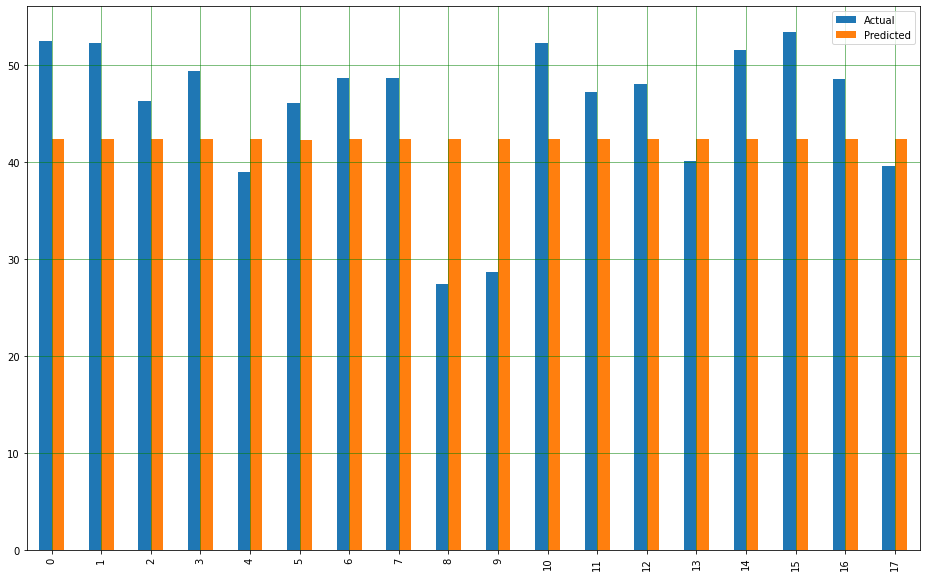

In [297]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [298]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 7.278608482063813
Mean Squared Error: 66.02790042411704
Root Mean Squared Error: 8.125755375601523


## Conclusion And Interpretation

##### From analysis we have observed that the sentiment normally has influence not on the market on the same day rather following day.The sentiment and Dow data can be treated as timeseries data and futher analysis can be done.
Apart from that for above analysis,the sample data is collected from tweeter only  for hash tag #Stock from jan to march.This small sample might not captured the true sentiment of tweeter data.    